In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [2]:
def import_res(modelname):
    filename = f"results\\RES_{modelname}.csv"
    return pd.read_csv(filename)


def import_consts(negative_prices=False):
    prices_B = pd.read_csv("./data/balance_dw.csv")['Generation / - Imbalance price [EUR/MWh] - MBA|DK2'].to_numpy()
    prices_S = pd.read_csv("./data/balance_up.csv")['Generation / + Imbalance price [EUR/MWh] - MBA|DK2'].to_numpy()
    prices_F = pd.read_csv("./data/forward.csv")["Price for consumption [EUR/MWh] - MBA|DK2"].to_numpy()
    if not negative_prices:
        prices_B = np.maximum(prices_B, 0)
        prices_S = np.maximum(prices_S, 0)
        prices_F = np.maximum(prices_F, 0)
    # forecast = pd.read_csv("./data/forecasts.csv")["Generation - Wind Offshore  [MW] Day Ahead/ BZN|DK2"].to_numpy()
    realized = pd.read_csv("./data/realized.csv")["Wind Offshore  - Actual Aggregated [MW]"].to_numpy()
    features = pd.read_csv("./data/features.csv").iloc[:, 1:].to_numpy()
    max_elec = 10
    max_wind = 13
    nominal_wind = 10
    qForecast = np.array([0.7770338357162985, 0.03580588292933596, 0.016086189924938307, -0.0074103664477346435, -1.5136952354991787e-5])
    qIntercept = -0.2673501276620584
    forecast = np.dot(features, qForecast)* max_wind + qIntercept
    price_H = 35.199999999999996
    max_value = np.maximum(np.max(realized), np.max(forecast))
    # forecast /= max_value
    realized /= max_value
    return prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, nominal_wind

In [3]:


def eval_hydro(df_res, qF):
    prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, nominal_wind = import_consts()
    obj = 0

    for i in range(df_res.shape[0]):
        if (prices_F[i] > price_H):
            forward_bid = qF[0]*forecast[i] + qF[1]
        else:
            forward_bid = 0
        # traded = realized[i] - forward_bid - df_res["hydrogen produced"][i]
        # bought = np.maximum(-traded, 0)
        # sold = np.maximum(traded, 0)
        sold = df_res["Power sold"][i]
        bought = df_res["Power bought"][i]

        obj += forward_bid * prices_F[i] + price_H*df_res["hydrogen produced"][i] + sold*prices_S[i] - bought*prices_B[i]
    
    return obj


def eval_without_hydro(df_res, qF):
    prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, nominal_wind = import_consts()
    obj = 0

    for i in range(df_res.shape[0]):
        forward_bid = qF[0]*forecast[i] + qF[1]
        # traded = realized[i] - forward_bid
        # bought = np.maximum(-traded, 0)
        # sold = np.maximum(traded, 0)
        sold = df_res["Power sold"][i]
        bought = df_res["Power bought"][i]

        obj += forward_bid * prices_F[i] + sold*prices_S[i] - bought*prices_B[i]
    
    return obj



In [4]:


def get_plot_info_hydro(df_res, qF):
    prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, nominal_wind = import_consts()
    obj = []
    h_prod = []
    selling = []
    buying = []
    bidding = []

    for i in range(df_res.shape[0]):
        if (prices_F[i] > price_H):
            forward_bid = qF[0]*forecast[i] + qF[1]
        else:
            forward_bid = 0
        # traded = realized[i] - forward_bid - df_res["hydrogen produced"][i]
        # bought = np.maximum(-traded, 0)
        # sold = np.maximum(traded, 0)
        sold = df_res["Power sold"][i]
        bought = df_res["Power bought"][i]

        selling.append(sold)
        buying.append(bought)
        bidding.append(forward_bid)
        h_prod.append(df_res["hydrogen produced"][i])
        obj.append(forward_bid * prices_F[i] + price_H*df_res["hydrogen produced"][i] + sold*prices_S[i] - bought*prices_B[i])
    
    return bidding, h_prod, selling, buying, obj

def get_plot_info_non_hydro(df_res, qF):
    prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, nominal_wind = import_consts()
    obj = []
    selling = []
    buying = []
    bidding = []

    for i in range(df_res.shape[0]):
        forward_bid = qF[0]*forecast[i] + qF[1]
        # traded = realized[i] - forward_bid
        # bought = np.maximum(-traded, 0)
        # sold = np.maximum(traded, 0)
        sold = df_res["Power sold"][i]
        bought = df_res["Power bought"][i]

        selling.append(sold)
        buying.append(bought)
        bidding.append(forward_bid)

        obj.append(forward_bid * prices_F[i] + sold*prices_S[i] - bought*prices_B[i])
    return bidding, selling, buying, obj
    

## Results

### 4-b

In [72]:
df_04a1 = import_res("04.a1")
df_04a2 = import_res("04.a2")
test_obj1 = eval_hydro(df_04a1, [0.9758988563049928,  0.23966924609541426])
test_obj2 = eval_without_hydro(df_04a2, [0.9758988563049928,  0.23966924609541426])
df_04a3 = import_res("04.a3")
df_04a4 = import_res("04.a4")
test_obj3 = eval_hydro(df_04a3, [0.5850605011807769,  0.1436839569308599])
test_obj4 = eval_without_hydro(df_04a4, [0.6958075967094669,  0.1708821370712849])
print(f"a1: {test_obj1}")
print(f"a2: {test_obj2}")
print(f"a3: {test_obj3}")
print(f"a4: {test_obj4}")

a1: 194946.95720265535
a2: 177052.3538516627
a3: 171214.94959055478
a4: 174290.89111570563


In [73]:
df_04a5 = import_res("04.a5")
df_04a6 = import_res("04.a6")
df_04a7 = import_res("04.a7")
df_04a8 = import_res("04.a8")
test_obj5 = eval_hydro(df_04a5, [1.0017624671856318,  0.24602104380582232])
test_obj6 = eval_without_hydro(df_04a6, [0.988552192158058,  0.2427767561051897])
test_obj7 = eval_hydro(df_04a7, [1.0017624671856318,  0.24602104380582232])
test_obj8 = eval_without_hydro(df_04a8, [0.9897096351560748,  0.24306101045075115])

print("Evaluation objectives:")
print(test_obj5)
print(test_obj6)
print(test_obj7)
print(test_obj8)

print("\n")
print("julia objectives")
print(df_04a5['Objective values'].sum())
print(df_04a6['Objective values'].sum())
print(df_04a7['Objective values'].sum())
print(df_04a8['Objective values'].sum())

Evaluation objectives:
195021.0450381016
177071.19651451256
195021.0450381016
177071.2819934157


julia objectives
195021.04503810132
174699.47255476267
195021.04503810132
177071.2819934156


In [74]:
bidding_h, h_prod, selling_h, buying_h, obj_h = get_plot_info_hydro(df_04a5, [1.0017624671856318,  0.24602104380582232])

bidding_nh, selling_nh, buying_nh, obj_nh = get_plot_info_non_hydro(df_04a6, [0.988552192158058,  0.2427767561051897])


In [75]:
prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, nominal_wind = import_consts()

bought_value_h = 0
bought_value_nh = 0

for i in range(df_04a5.shape[0]):
    if (prices_B[i] > 0):
        bought_value_h += prices_B[i]*df_04a5['Power bought'][i] - price_H*(df_04a5['Power bought'][i])
        bought_value_nh += prices_B[i]*df_04a6['Power bought'][i]


print(bought_value_h)
print(bought_value_nh)

6489.0900206054375
15099.5892278169


##### Plotting

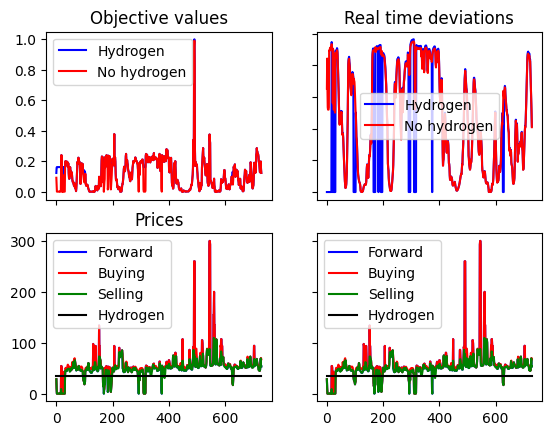

In [76]:
from matplotlib.pyplot import subplot


prices_B, prices_S, prices_F, forecast, realized, price_H, max_elec, nominal_wind = import_consts()
xs = range(df_04a5.shape[0])
h_price = np.ones(df_04a5.shape[0])*price_H


qF_h = [1.0017624671856318,  0.24602104380582232]
qF_nh = [0.988552192158058,  0.2427767561051897]

forecast_error_h = np.abs(realized - (forecast[:8760]*qF_h[0] + qF_h[1]))
forecast_error_nh = np.abs(realized - (forecast[:8760]*qF_nh[0] + qF_nh[1]))

for i in xs:
    if prices_F[i] < price_H:
        forecast_error_h[i] = 0

#------------------------------------------------
# f = figure()
# plt.plot(xs, h_prod/np.max(h_prod), 'b')
# plt.plot(xs, prices_F[xs]/np.max(prices_F[xs]), 'g')
# plt.plot(xs, prices_B[xs]/np.max(prices_F[xs]), 'g')
# plt.plot(xs, prices_S[:730]/np.max(prices_F[:730]), 'g')
# plt.plot(xs, prices_B[:730]/np.max(prices_F[:730]), 'k')
# plt.plot(xs, selling_nh[:730]/np.max(selling_h[:730]), 'r')
# plt.plot(xs, selling_h[:730]/np.max(selling_h[:730]), 'b')
# plt.plot(xs, h_price/np.max(prices_F[:730]))
#------------------------------------------------
# f, axs = subplot(2)
# axs[0].plot(xs, obj_h/np.max(obj_h), 'b')
# axs[0].plot(xs, obj_nh/np.max(obj_h), 'r')
# axs[1].plot(xs, forecast_error_h[:730]/np.max(forecast_error_h), 'b')
# axs[1].plot(xs, forecast_error_nh[:730]/np.max(forecast_error_h), 'r')
# axs[2].plot(xs, prices_F[xs]/np.max(prices_F[xs]), 'b')
# axs[2].plot(xs, prices_B[xs]/np.max(prices_F[xs]), 'r')
# axs[2].plot(xs, prices_S[:730]/np.max(prices_F[:730]), 'g')
#------------------------------------------------
fig, axs = plt.subplots(2, 2)
axs[0, 0].plot(xs, obj_h/np.max(obj_h), 'b', label="Hydrogen")
axs[0, 0].plot(xs, obj_nh/np.max(obj_h), 'r', label="No hydrogen")
axs[0, 0].set_title('Objective values')
axs[0, 1].plot(xs, forecast_error_h[:730]/np.max(forecast_error_h), 'b', label="Hydrogen")
axs[0, 1].plot(xs, forecast_error_nh[:730]/np.max(forecast_error_h), 'r', label="No hydrogen")
axs[0, 1].set_title('Real time deviations')
axs[1, 0].plot(xs, prices_F[xs], 'b', label="Forward")
axs[1, 0].plot(xs, prices_B[xs], 'r', label="Buying")
axs[1, 0].plot(xs, prices_S[:730], 'g', label="Selling")
axs[1, 0].plot(xs, h_price, 'k', label="Hydrogen")
axs[1, 1].plot(xs, prices_F[xs], 'b', label="Forward")
axs[1, 1].plot(xs, prices_B[xs], 'r', label="Buying")
axs[1, 1].plot(xs, prices_S[:730], 'g', label="Selling")
axs[1, 1].plot(xs, h_price, 'k', label="Hydrogen")

axs[1, 0].set_title('Prices')
# axs[1, 1].plot(x, -y, 'tab:red')
# axs[1, 1].set_title('Axis [1, 1]')
for ax in axs.flat:
    ax.legend()
    ax.label_outer()
plt.show()

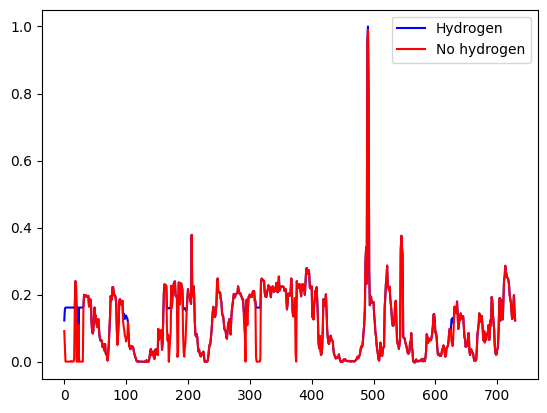

In [77]:
f = plt.figure()
plt.plot(xs, obj_h/np.max(obj_h), 'b', label="Hydrogen")
plt.plot(xs, obj_nh/np.max(obj_h), 'r', label="No hydrogen")
plt.legend()
plt.show()

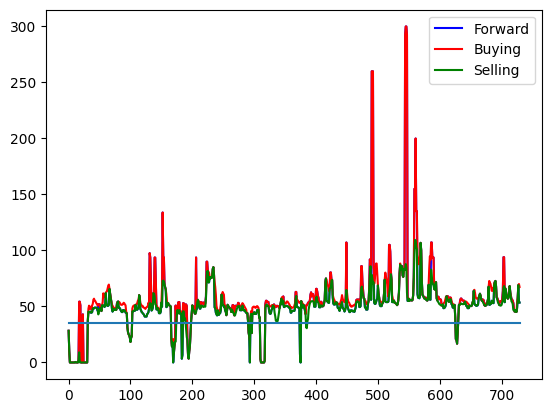

In [78]:

f = plt.figure()
plt.plot(xs, prices_F[xs], 'b', label="Forward")
plt.plot(xs, prices_B[xs], 'r', label="Buying")
plt.plot(xs, prices_S[:730], 'g', label="Selling")
plt.plot(xs, h_price)
plt.legend()
plt.show()

##### Detailed print

In [79]:


for i in range(350, 360):

    print(f"\n\nt = {i}")
    print("HYDROGEN:")
    print(f" obj: {df_04a5['Objective values'][i]}")
    # print(f" bought: {df_04a5['Power bought'][i]}")
    # print(f" sold: {df_04a5['Power sold'][i]}")
    # print(f" foward bid: {df_04a5['Forward bid'][i]}")
    # print(f" h-production: {df_04a5['hydrogen produced'][i]}")

    print("NO HYDROGEN:")
    print(f" obj: {df_04a6['Objective values'][i]}")
    # print(f" bought: {df_04a6['Power bought'][i]}")
    # print(f" sold: {df_04a6['Power sold'][i]}")
    # print(f" foward bid: {df_04a6['Forward bid'][i]}")



t = 350
HYDROGEN:
 obj: 488.46431491217567
NO HYDROGEN:
 obj: 488.7423428118411


t = 351
HYDROGEN:
 obj: 488.423050143065
NO HYDROGEN:
 obj: 488.70162220261545


t = 352
HYDROGEN:
 obj: 487.91194251223664
NO HYDROGEN:
 obj: 488.3606758374055


t = 353
HYDROGEN:
 obj: 490.56632266055226
NO HYDROGEN:
 obj: 491.0935065453068


t = 354
HYDROGEN:
 obj: 487.1866503449149
NO HYDROGEN:
 obj: 487.7478594502089


t = 355
HYDROGEN:
 obj: 483.4538665667945
NO HYDROGEN:
 obj: 483.8860616952888


t = 356
HYDROGEN:
 obj: 459.74797816913207
NO HYDROGEN:
 obj: 460.1309972037999


t = 357
HYDROGEN:
 obj: 468.0827586206896
NO HYDROGEN:
 obj: 468.0827586206896


t = 358
HYDROGEN:
 obj: 471.9405835543765
NO HYDROGEN:
 obj: 471.94058355437664


t = 359
HYDROGEN:
 obj: 421.39257294429706
NO HYDROGEN:
 obj: 421.39257294429706


In [80]:
#-----------SINGLE OBJECTIVE VALUE
qF_hyd = [1.0017624671856318,  0.24602104380582232]
calc_bid = qF_hyd[0]*forecast[100] + qF_hyd[1]
traded_h = realized[100] - df_04a5["hydrogen produced"][100]
bought_h = np.maximum(-traded_h, 0)
sold_h = np.maximum(traded_h, 0)
traded_nh = realized[100] - calc_bid
bought_nh = np.maximum(-traded_nh, 0)
sold_nh = np.maximum(traded_nh, 0)

print(prices_F[100]*calc_bid + prices_S[100]*sold_nh - prices_B[100]*bought_nh)
print(price_H*h_prod[100] + prices_S[100]*sold_h - prices_B[100]*bought_h)

13.15623342175067
181.4562334217506


### 4-c

In [18]:
df_qs = pd.read_csv("results/validation_results_02.csv")
df_qs.head()

,One month window,Six month window,Eleven month window
0,0.990483,1.000677,1.048245
1,0.243251,0.567040,0.302501
2,0.962630,1.096600,0.960851
3,0.222403,0.295765,0.592254
4,0.963882,1.082347,0.948916


In [19]:
df_q1s = df_qs[df_qs.reset_index().index % 2 == 0]  # Selects every 2nd row starting from 0
df_q2s = df_qs[df_qs.reset_index().index % 2 != 0]  # Excludes every 2nd row starting from 0

C:\Users\emilh\AppData\Local\Temp\ipykernel_23304\3872104054.py:12: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


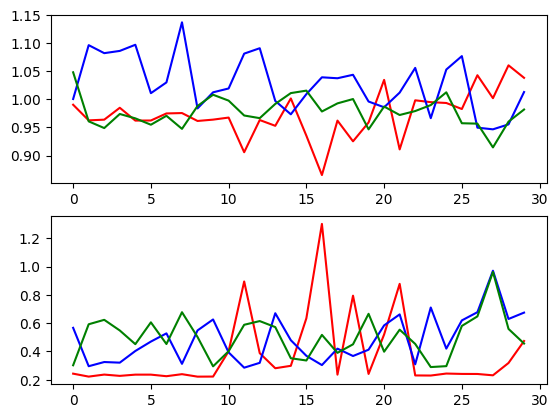

In [26]:
# 0.978414	1.012614	1.006788
f, ax = plt.subplots(2)
xs = range(len(df_q1s["One month window"]))
ax[0].plot(xs, df_q1s["One month window"], 'r')
ax[0].plot(xs, df_q1s["Six month window"], 'b')
ax[0].plot(xs, df_q1s["Eleven month window"], 'g')

ax[1].plot(xs, df_q2s["One month window"], 'r')
ax[1].plot(xs, df_q2s["Six month window"], 'b')
ax[1].plot(xs, df_q2s["Eleven month window"], 'g')

f.show()
